# Import

In [1]:
import math
import random
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import poisson
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
from catboost import CatBoostRegressor

SEED = 42

In [2]:
def line_plot(y_test, y_pred, plot_value, value, plot_name=None):

    plot_data = [('white', 'red', '#4682B4', ''), ('white', 'black', 'gray', '_colored')]
    for color, marker_color, line_color, suffix in plot_data:
        plt.figure(figsize=(8, 4))  # Create separate figures
        sns.lineplot(y_test, label='Истинное значение', color=color, marker='o', markersize=5, markerfacecolor=marker_color)
        sns.lineplot(y_pred, label='Оцененное значение', color=line_color)  # Simplified
        plt.xlim(0, plot_value)
        plt.ylim(0, round(max(test_intervals_Y[:plot_value, value])))
        plt.xlabel('Количество данных', fontsize=12)
        plt.ylabel('Значение данных', fontsize=12)
        plt.grid(alpha=0.5, color='black')
        plt.legend(loc=1) # Add a legend to distinguish lines

        filename = f'{plot_name}{suffix}.pdf' if plot_name else None
        if filename:
            plt.savefig(f'{filename}', bbox_inches="tight")


def scatter_plot(y_test, y_pred, lim_value, plot_name=None):
    """Creates two separate scatter plots, optimized for efficiency."""
    plot_data = [(None, ''), ('grey', '_colored')]  # Store plot parameters
    for color, suffix in plot_data:
        plt.figure(figsize=(8, 4))  # Create new figure for each plot
        sns.scatterplot(x=y_test, y=y_pred, alpha=0.5, color=color)  # Use color directly
        sns.lineplot(x=[0, lim_value], y=[0, lim_value], color='black')
        plt.xlim(0, lim_value)
        plt.ylim(0, lim_value)
        plt.xlabel('Истинные значения', fontsize=12)
        plt.ylabel('Предсказанные значения', fontsize=12)
        plt.grid(alpha=0.5, color='black')

        filename = f'{plot_name}{suffix}.pdf' if plot_name else None
        if filename:
            plt.savefig(f'{filename}', bbox_inches="tight")

def reccur_potok(alpha, beta):
    return random.uniform(alpha, beta)


def gen_recurr(row, col, y_pred1, y_pred2):
    time_list = np.zeros((row, col)) # Use numpy array directly
    alpha_list = y_pred1 # Vectorized alpha and beta extraction
    beta_list = y_pred2

    for i in range(row):
        time = 0
        for j in range(col):
            time += reccur_potok(abs(alpha_list[i]), abs(beta_list[i])) # Use pre-calculated alpha and beta
            time_list[i, j] = time # Use numpy indexing

    df_prov = pd.DataFrame(time_list)
    df_prov['alpha_value'] = alpha_list
    df_prov['beta_value'] = beta_list
    return df_prov

def print_curve_metrics(X_test_interval, df_prov_interval, itog_itog_list):
    relative_error_mean_list = []
    relative_error_std_list = []
    for i in range(X_test_interval.shape[0]):
        relative_error_mean_list.append(abs(X_test_interval.iloc[i].mean() - df_prov_interval.iloc[i].mean()) / X_test_interval.iloc[i].mean())
        relative_error_std_list.append(abs(X_test_interval.iloc[i].std() - df_prov_interval.iloc[i].std()) / X_test_interval.iloc[i].std())

    abs_list = []
    abs_itog_list = itog_itog_list
    for i in range(X_test_interval.shape[0]):
        for j in range(X_test_interval.shape[1]):
            abs_itog_list[i][j] = abs(itog_itog_list[i][j])
        abs_list.append(max(itog_itog_list[i]))

    metrics_df = pd.DataFrame({
        'relative_error_mean': relative_error_mean_list,
        'relative_error_std': relative_error_std_list,
        'abs_list': abs_list
    })
    
    # Вычисление средних и медианных значений
    test_result_mean = {
        'relative_error_mean_mean': metrics_df['relative_error_mean'].mean(),
        'relative_error_mean_median': metrics_df['relative_error_mean'].median(),
        'relative_error_std_mean': metrics_df['relative_error_std'].mean(),
        'relative_error_std_median': metrics_df['relative_error_std'].median(),
        'abs_mean': metrics_df['abs_list'].mean(),
        'abs_median': metrics_df['abs_list'].median()
    }

    metrics_mean_df = pd.DataFrame([test_result_mean])

    # Вывод результатов
    for key, value in test_result_mean.items():
        print(f'{key}:\t{value:.3f}')
        
    return 


def evaluate_regression(y_true, y_pred, param_name):
    """Evaluates regression performance."""

    mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    r2 = r2_score(y_true, y_pred)
    mae = mean_absolute_error(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)

    print(f"\n{param_name}")
    print(f'MAE: {mae:.3f}')
    print(f'MSE: {mse:.3f}')
    print(f'RMSE: {rmse:.3f}')
    print(f'MAPE: {mape:.3f}%')
    print(f'R² Score: {r2:.3f}')
    
    return # No need to explicitly return None

def get_intervals_from_df(df):
    intervals = df.diff(axis=1).iloc[:, 1:]
    intervals.columns = range(intervals.shape[1])
    return intervals

def calculate_statistics(X):
    """Вычисляет статистические характеристики для матрицы наблюдений X."""

    n_observations = X.shape[0]
    stat_M = np.zeros((n_observations, 10))

    # Векторизованные вычисления для основных статистик
    stat_M[:, 0] = np.mean(X, axis=1)
    stat_M[:, 1] = np.var(X, axis=1)
    stat_M[:, 2] = np.std(X, axis=1)
    stat_M[:, 3] = stat_M[:, 2] / stat_M[:, 0]  # Коэффициент вариации

    # Квантили. Избегаем повторного вычисления квантилей
    quantiles = [0.1, 0.25, 0.5, 0.75, 0.9, 0.95]
    quantiles_values = np.quantile(X, quantiles, axis=1)
    stat_M[:, 4:10] = quantiles_values.T # Транспонируем, чтобы правильно разместить

    return stat_M

# Read and split

In [3]:
df = pd.read_csv("/home/jupyter/datasphere/datasets/datasets/uni.csv", sep=",", index_col=0)

In [4]:
df.shape

(10000, 10003)

In [5]:
df.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,9963,9964,9965,9966,9967,9968,9969,9970,9971,9972,9973,9974,9975,9976,9977,9978,9979,9980,9981,9982,9983,9984,9985,9986,9987,9988,9989,9990,9991,9992,9993,9994,9995,9996,9997,9998,9999,a,b,lmbd
0,5.841149,8.054129,15.896704,18.191281,22.652389,30.633680,37.878149,41.445934,47.849156,55.395673,60.211749,66.072233,68.764525,76.273591,79.733470,86.564866,90.237558,94.610732,96.800612,104.179413,112.344526,115.511380,121.219392,123.604369,124.572018,128.144776,133.074516,135.348215,138.474821,143.507501,145.904592,148.338657,149.755680,154.516087,162.328500,166.582464,168.233287,170.237054,175.580061,180.990938,...,45729.474067,45736.398173,45741.880261,45749.992628,45755.324130,45758.088676,45759.698581,45762.454715,45765.569310,45768.440998,45776.129804,45779.611065,45781.891214,45785.754067,45792.411837,45799.087455,45806.207944,45812.862740,45815.703576,45820.254933,45821.543827,45828.686741,45833.803946,45836.321451,45839.101379,45844.328167,45848.649686,45855.574184,45863.708712,45870.497494,45875.226502,45880.243489,45886.249808,45887.523348,45895.497964,45898.317198,45900.399572,0.883494,8.234477,0.219347
1,0.935867,3.311512,6.009255,10.113999,13.803006,18.700333,26.399568,32.544032,33.840017,37.507671,39.628480,47.207446,50.905854,55.675380,61.749472,66.897601,68.884327,69.621688,74.153872,76.934623,78.029877,79.192541,81.351022,86.158869,91.109760,92.115175,94.829496,98.330838,105.857372,109.139414,112.743523,119.102958,121.555135,126.497635,130.115800,133.803630,136.326342,143.573720,149.032048,152.864954,...,39627.147112,39632.244422,39633.489569,39637.764596,39640.793554,39648.389521,39652.686928,39654.812133,39656.929356,39660.844398,39667.562364,39668.332473,39674.515967,39675.160052,39682.332618,39687.773488,39692.212936,39696.566627,39700.639246,39705.060314,39710.632915,39712.578851,39719.898560,39727.057013,39728.980990,39729.756421,39736.378980,39743.377698,39744.050489,39744.536686,39749.690808,39752.085980,39758.699675,39765.460264,39765.831069,39767.627155,39772.266149,0.085237,7.811444,0.253271
2,1.386866,4.707845,9.224782,12.588937,17.240292,20.989939,24.548863,26.507857,28.458886,31.381819,36.497934,39.892614,42.565113,47.659061,49.481408,52.561611,56.729189,57.291056,58.408094,60.225188,60.859286,61.493699,62.104300,65.620419,69.985385,74.667090,75.236904,79.798525,84.627308,87.616386,91.493260,93.351081,98.258062,102.288577,103.381028,106.893927,111.142958,115.505388,119.088615,123.352402,...,28692.125788,28697.416851,28700.046696,28703.014863,28706.929521,28710.635136,28712.147468,28713.060258,28716.979143,28719.123926,28723.175343,28727.887604,28728.628531,28729.170843,28729.979981,28731.100428,28735.907580,28739.866740,28744.455432,28746.889732,28747.987969,28751.236072,28753.205648,28753.937297,28755.908882,28757.505618,28759.744851,28763.145199,28764.318923,28769.499717,28773.581639,28776.857229,28780.757244,28783.242880,28784.003626,28788.381006,28790.961084,0.407289,5.306193,0.350049
3,1.825051,3.060429,5.922569,8.321759,13.142293,15.741791,19.566854,21.916859,22.954162,27.708716,31.183064,37.163241,42.384574,43.196497,48.498156,53.880729,55.555374,62.198377,67.032727,72.996785,74.148124,81.022804,86.389478,92.065274,99.264987,100.732088,107.941420,114.937962,119.184385,125.236007,127.837857,132.055565,133.881306,139.785884,144.856751,151.587031,157.815742,161.275620,162.960778,165.698986,...,40449.518343,40454.846259,40460.571515,40463.067408,40469.112267,40470.348033,40472.692217,40479.290185,40483.684496,40490.223069,40491.441346,40497.181898,40502.467606,40509.132304,40511.698176,40513.551808,40519.112403,40520.010771,40521.459498,40527.887186,40533.357062,40535.467175,40538.258497,40544.823743,40552.141832,40558.259007,40562.361775,40566.797318,40573.126831,40574.488183,40577.498609,40584.809186,40591.884006,40598.932848,40605.664244,40607.479402,40611.657783,0.807432,7.381308,0

In [6]:
intervals_df = get_intervals_from_df(df.iloc[0:10000, :10000])
intervals_df['a'] = df['a']
intervals_df['b'] = df['b']
intervals_df['lmbd'] = df['lmbd']

In [7]:
intervals_df.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,9962,9963,9964,9965,9966,9967,9968,9969,9970,9971,9972,9973,9974,9975,9976,9977,9978,9979,9980,9981,9982,9983,9984,9985,9986,9987,9988,9989,9990,9991,9992,9993,9994,9995,9996,9997,9998,a,b,lmbd
0,2.212980,7.842574,2.294578,4.461107,7.981291,7.244469,3.567785,6.403222,7.546518,4.816075,5.860485,2.692292,7.509066,3.459879,6.831396,3.672691,4.373174,2.189880,7.378801,8.165113,3.166853,5.708013,2.384977,0.967649,3.572758,4.929740,2.273699,3.126606,5.032680,2.397092,2.434065,1.417022,4.760407,7.812413,4.253964,1.650823,2.003767,5.343008,5.410877,7.099114,...,6.247499,6.924106,5.482088,8.112367,5.331502,2.764546,1.609905,2.756134,3.114595,2.871689,7.688806,3.481261,2.280149,3.862853,6.657770,6.675618,7.120488,6.654796,2.840837,4.551357,1.288894,7.142914,5.117205,2.517506,2.779927,5.226789,4.321519,6.924498,8.134529,6.788782,4.729008,5.016987,6.006318,1.273541,7.974616,2.819233,2.082375,0.883494,8.234477,0.219347
1,2.375645,2.697742,4.104745,3.689007,4.897326,7.699236,6.144463,1.295986,3.667654,2.120809,7.578966,3.698408,4.769526,6.074093,5.148129,1.986726,0.737361,4.532184,2.780752,1.095254,1.162664,2.158480,4.807848,4.950891,1.005415,2.714321,3.501342,7.526534,3.282043,3.604109,6.359435,2.452177,4.942500,3.618165,3.687830,2.522713,7.247378,5.458328,3.832907,7.317089,...,6.022397,5.097310,1.245147,4.275027,3.028958,7.595968,4.297407,2.125205,2.117223,3.915042,6.717966,0.770109,6.183494,0.644085,7.172566,5.440869,4.439449,4.353690,4.072619,4.421069,5.572601,1.945936,7.319709,7.158453,1.923977,0.775431,6.622559,6.998718,0.672790,0.486197,5.154122,2.395172,6.613695,6.760589,0.370805,1.796086,4.638994,0.085237,7.811444,0.253271
2,3.320979,4.516936,3.364155,4.651355,3.749648,3.558923,1.958995,1.951029,2.922933,5.116115,3.394679,2.672500,5.093947,1.822348,3.080203,4.167577,0.561868,1.117038,1.817093,0.634098,0.634414,0.610600,3.516119,4.364966,4.681706,0.569814,4.561621,4.828783,2.989078,3.876874,1.857821,4.906981,4.030516,1.092451,3.512899,4.249031,4.362430,3.583227,4.263786,2.460394,...,1.858185,5.291062,2.629846,2.968166,3.914659,3.705615,1.512332,0.912790,3.918884,2.144783,4.051417,4.712262,0.740926,0.542313,0.809137,1.120447,4.807153,3.959160,4.588692,2.434300,1.098237,3.248102,1.969576,0.731649,1.971585,1.596736,2.239234,3.400347,1.173724,5.180794,4.081922,3.275590,3.900015,2.485635,0.760746,4.377380,2.580078,0.407289,5.306193,0.350049
3,1.235378,2.862139,2.399190,4.820535,2.599498,3.825063,2.350005,1.037303,4.754554,3.474348,5.980177,5.221333,0.811923,5.301658,5.382573,1.674645,6.643004,4.834350,5.964058,1.151339,6.874681,5.366673,5.675796,7.199714,1.467101,7.209332,6.996542,4.246423,6.051622,2.601850,4.217708,1.825741,5.904578,5.070867,6.730280,6.228711,3.459878,1.685158,2.738209,1.877796,...,6.104909,5.327917,5.725256,2.495893,6.044859,1.235766,2.344184,6.597968,4.394311,6.538573,1.218278,5.740552,5.285708,6.664698,2.565872,1.853632,5.560595,0.898368,1.448727,6.427687,5.469876,2.110114,2.791322,6.565246,7.318090,6.117175,4.102768,4.435542,6.329513,1.361352,3.010426,7.310577,7.074820,7.048843,6.731396,1.815158,4.178381,0.807432,7.381308,0.244238
4,0.147948,0.200970,0.314533,0.101130,0.256902,0.171164,0.118028,0.157016,0.090571,0.158540,0.215314,0.205433,0.202946,0.063443,0.336082,0.301740,0.110086,0.208775,0.179531,0.342823,0.256594,0.274683,0.272442,0.347696,0.104892,0.326857,0.174912,0.187751,0.232123,0.112612,0.278406,0.232319,0.173464,0.083886,0.302427,0.116975,0.116866,0.111698,0.067292,0.270037,...,0.164291,0.161203,0.254057,0.084134,0.297486,0.168194,0.162728,0.171166,0.184935,0.223412,0.201886,0.138253,0.224055,0.142804,0.341092,0.214607,0.098944,0.260568,0.246141,0.142765,0.262879,0.118631,0.291584,0.057685,0.230800,0.206248,0.266245,0.074185,0.282952,0.074334,0.242492,0.174457,0.201657,0.113422,0.208771,0.096836,0.184676,0.056882,0.350276,4.912101


In [8]:
train_intervals_df, test_intervals_df = train_test_split(intervals_df, train_size=0.8, random_state=SEED, shuffle=True)

In [9]:
test_intervals_df, val_intervals_df = train_test_split(test_intervals_df, train_size=0.7, random_state=SEED, shuffle=True)

In [10]:
train_intervals_X = np.array(train_intervals_df)[:, :9999]
train_intervals_Y = np.array(train_intervals_df)[:, 9999:]
test_intervals_X = np.array(test_intervals_df)[:, :9999]
test_intervals_Y = np.array(test_intervals_df)[:, 9999:]
val_intervals_X = np.array(val_intervals_df)[:, :9999]
val_intervals_Y = np.array(val_intervals_df)[:, 9999:]

# Метод моментов

In [19]:
mean_empirical = test_intervals_X.mean(axis=1)
moment2_empirical = (test_intervals_X**2).mean(axis=1)
var_emp = test_intervals_X.var(axis=1)

In [24]:
import sympy as sp
import numpy as np
from sympy import symbols, Eq, solve

def solve_uniform_symbolic(mean_emp_values, var_emp_values):

    a, b = symbols('a b')  # Определяем символьные переменные

    results = []  # Список для хранения результатов
    for mean_emp, var_emp in zip(mean_emp_values, var_emp_values):

        # Проверка на допустимость var_emp (дисперсия должна быть неотрицательной)
        if var_emp <= 0:
            results.append(None)  # Если var_emp <= 0, возвращаем None
            continue

        # Создание системы уравнений (внутри цикла для каждой пары mean и var)
        system_of_equations = [Eq((a + b) / 2, mean_emp),
                               Eq((b - a)**2 / 12, var_emp)]

        try:
            # Решение системы уравнений (внутри цикла)
            solutions = solve(system_of_equations, (a, b))

            # Проверка наличия решений
            if solutions:
                # Вывод результатов
                # Выберем одно из решений (обычно первое) и преобразуем его в числовые значения.
                a_sol, b_sol = solutions[0] # Берем первое решение

                # Преобразуем sympy объекты в numpy float
                a_val = float(a_sol)
                b_val = float(b_sol)

                results.append((a_val, b_val))
            else:
                results.append(None)  # Если решений нет, возвращаем None

        except NotImplementedError as e:
            print(f"Не удалось решить символьно для mean={mean_emp}, var={var_emp}: {e}")
            results.append(None)
        except Exception as e:
            print(f"Другая ошибка при решении для mean={mean_emp}, var={var_emp}: {e}")
            results.append(None)

    return results

# --- Пример использования ---
# Решаем символьно для каждой пары mean и var
solutions = solve_uniform_symbolic(mean_empirical, var_emp)

a_list = []
b_list = []
for i, sol in enumerate(solutions):
    a, b = sol
    a_list.append(a)
    b_list.append(b)

In [25]:
evaluate_regression(test_intervals_Y[:, 0], a_list, "value1")
evaluate_regression(test_intervals_Y[:, 1], b_list, "value2")


value1
MAE: 0.014
MSE: 0.000
RMSE: 0.020
MAPE: 6.751%
R² Score: 0.995

value2
MAE: 0.014
MSE: 0.000
RMSE: 0.020
MAPE: 0.251%
R² Score: 1.000


# Catboost

## Catboost интервалы

In [8]:
#%pip install catboost

In [ ]:
params = {
    "loss_function": "MultiRMSE",
    "verbose": 100,
    "random_seed": SEED,
    #"task_type": "GPU",  # Уберите, если у вас нет GPU
    "iterations": 2000,
    "early_stopping_rounds": 200,
    #"l2_leaf_reg": 3,
    #"depth": 8,
    #"learning_rate": 0.03
}

lognorm_inter = CatBoostRegressor(**params)

# Обучение с использованием валидационной выборки
lognorm_inter.fit(train_intervals_X, train_intervals_Y, eval_set=(val_intervals_X, val_intervals_Y), use_best_model=True)

0:	learn: 2.7719482	test: 2.6999830	best: 2.6999830 (0)	total: 623ms	remaining: 20m 46s
100:	learn: 0.5949009	test: 0.5733833	best: 0.5733833 (100)	total: 44s	remaining: 13m 46s
200:	learn: 0.3610909	test: 0.3836324	best: 0.3836324 (200)	total: 1m 25s	remaining: 12m 44s
300:	learn: 0.2870328	test: 0.3188744	best: 0.3188744 (300)	total: 2m 7s	remaining: 12m
400:	learn: 0.2405123	test: 0.2801471	best: 0.2801471 (400)	total: 2m 50s	remaining: 11m 18s
500:	learn: 0.2088341	test: 0.2568407	best: 0.2568407 (500)	total: 3m 33s	remaining: 10m 37s


In [13]:
pred = lognorm_inter.predict(test_intervals_X)

In [15]:
lognorm_inter.save_model("lognorm_inter_gamma")

In [16]:
# gamma_inter = CatBoostRegressor() 
# gamma_inter.load_model('/home/jupyter/datasphere/project/recurr_gamma')
# pred = gamma_inter.predict(test_intervals_X)

### Метрики

In [14]:
# Оценка качества для первого параметра
evaluate_regression(test_intervals_Y[:, 0], pred[:, 0], "value1")

# Оценка качества для второго параметра
evaluate_regression(test_intervals_Y[:, 1], pred[:, 1], "value2")
evaluate_regression(test_intervals_Y[:, 2], pred[:, 2], "value3")


value1
MAE: 0.061
MSE: 0.006
RMSE: 0.079
MAPE: 34.250%
R² Score: 0.926

value2
MAE: 0.142
MSE: 0.037
RMSE: 0.191
MAPE: 3.126%
R² Score: 0.995

value3
MAE: 0.032
MSE: 0.010
RMSE: 0.101
MAPE: 5.164%
R² Score: 0.977


In [ ]:
value1
MAE: 0.017
MSE: 0.001
RMSE: 0.023
MAPE: 7.696%
R² Score: 0.994

value2
MAE: 0.028
MSE: 0.001
RMSE: 0.036
MAPE: 0.809%
R² Score: 1.000

value3
MAE: 0.016
MSE: 0.028
RMSE: 0.168
MAPE: 0.993%
R² Score: 0.936

In [15]:
train_df, test_df = train_test_split(df, train_size=0.8, random_state=SEED, shuffle=True)
test_df, val_df = train_test_split(test_df, train_size=0.7, random_state=SEED, shuffle=True)

test_df_X = np.array(test_df)[:, :10000]
test_df_Y = np.array(test_df)[:, 10000:10002]

test_df_gen = gen_recurr(test_df_X.shape[0], test_df_X.shape[1], pred[:,0], pred[:,1])

test_interval_df_gen = get_intervals_from_df(test_df_gen.iloc[:, :10000])

In [16]:
a = test_df_X[0:test_df_X.shape[0], :test_df_X.shape[1]]
b = np.array(test_df_gen.iloc[0:test_df_X.shape[0], :test_df_X.shape[1]])

itog_itog_list = []

for i in range(test_df_X.shape[0]):
    itog_list = []
    n_cols = test_df_X.shape[1] # Store this value to avoid repeated access

    if np.max(a[i]) > np.max(b[i]): # Use NumPy's max for efficiency
        counter1 = 0
        counter2 = 0
        while counter1 < n_cols and counter2 < n_cols: #Ensure no index errors
            diff = counter1 - counter2
            if a[i][counter1] < b[i][counter2]:
                counter1 += 1
            elif a[i][counter1] > b[i][counter2]:
                counter2 += 1
            else:
                counter1 += 1
                counter2 += 1
            itog_list.append(abs(diff))
    else:
        counter1 = 0
        counter2 = 0
        while counter1 < n_cols and counter2 < n_cols: #Ensure no index errors
            diff = counter1 - counter2
            if a[i][counter1] < b[i][counter2]:
                counter1 += 1
            elif a[i][counter1] > b[i][counter2]:
                counter2 += 1
            else:
                counter1 += 1
                counter2 += 1
            itog_list.append(abs(diff))

    itog_itog_list.append(itog_list)

In [17]:
print_curve_metrics(test_intervals_df.iloc[:, :9999], test_interval_df_gen, itog_itog_list)

relative_error_mean_mean:	0.026
relative_error_mean_median:	0.021
relative_error_std_mean:	0.066
relative_error_std_median:	0.034
abs_mean:	269.206
abs_median:	213.000


### Рисунки

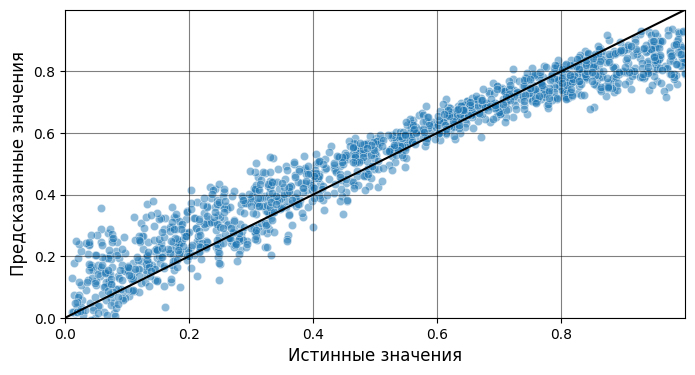

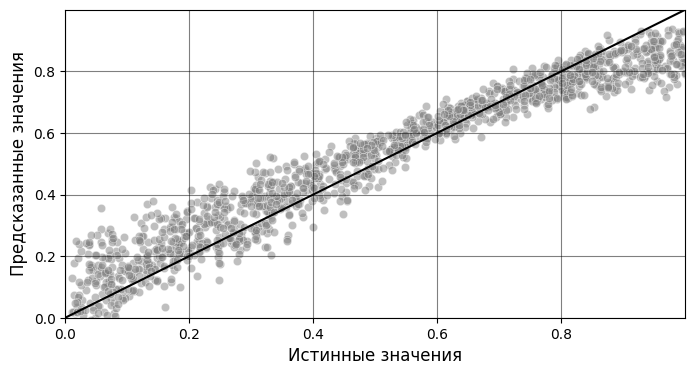

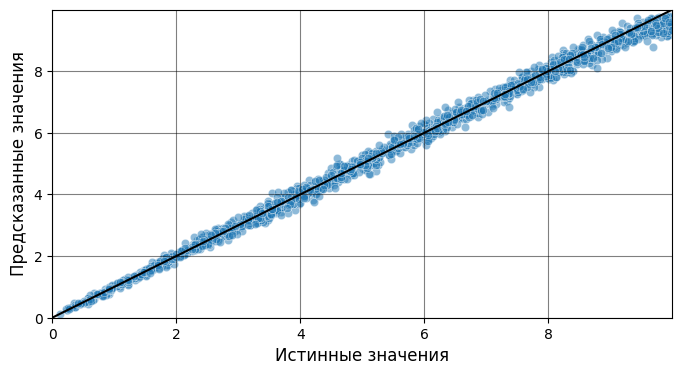

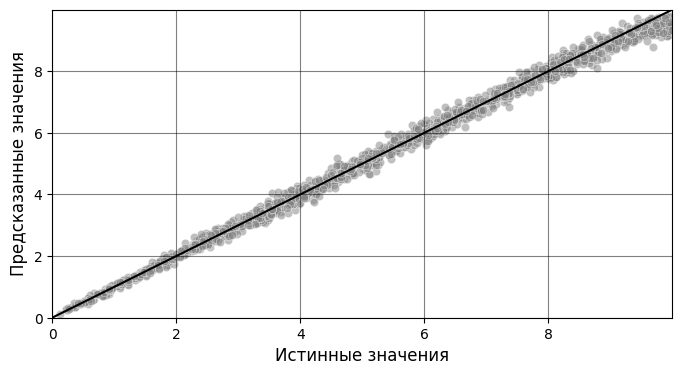

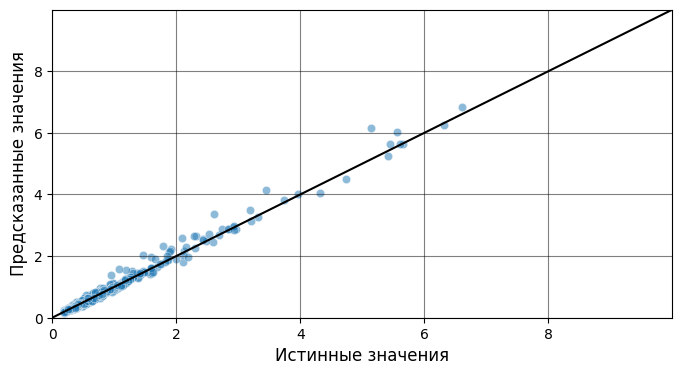

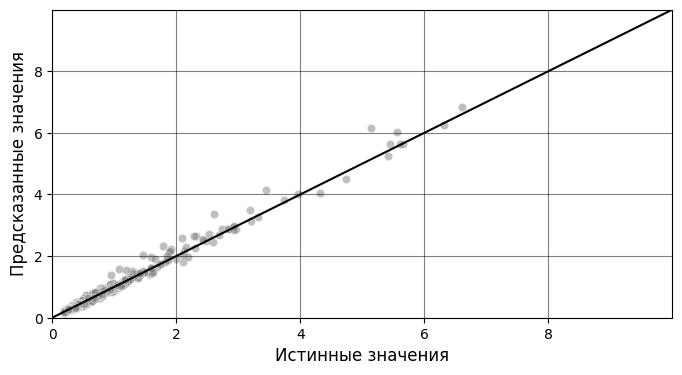

In [25]:
scatter_plot(test_intervals_Y[:,0], pred[:,0], max(test_intervals_Y[:,0]), "/home/jupyter/datasphere/project/uniform/Untitled Folder/val1")

scatter_plot(test_intervals_Y[:,1], pred[:,1], max(test_intervals_Y[:,1]), "/home/jupyter/datasphere/project/uniform/Untitled Folder/val2")

scatter_plot(test_intervals_Y[:,2], pred[:,2], max(test_intervals_Y[:,1]), "/home/jupyter/datasphere/project/uniform/Untitled Folder/val3")

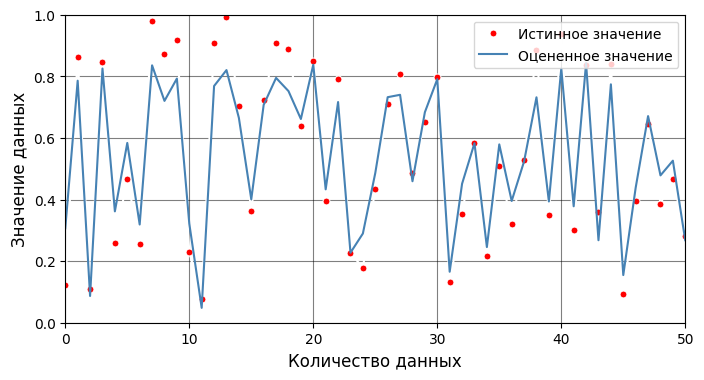

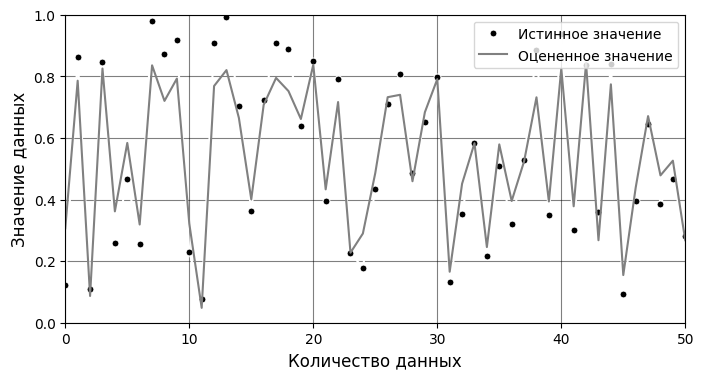

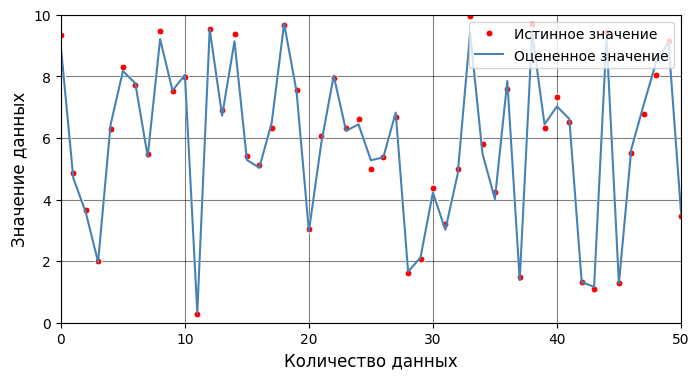

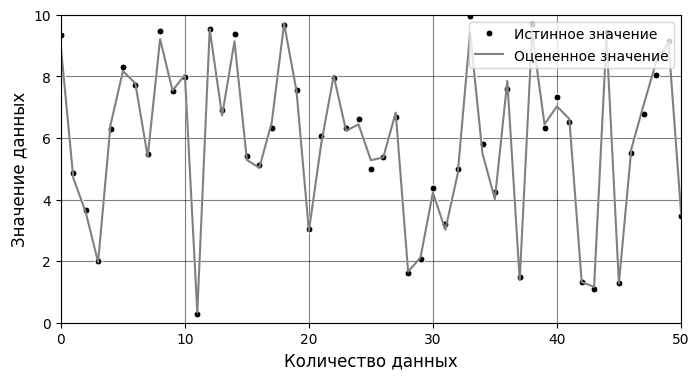

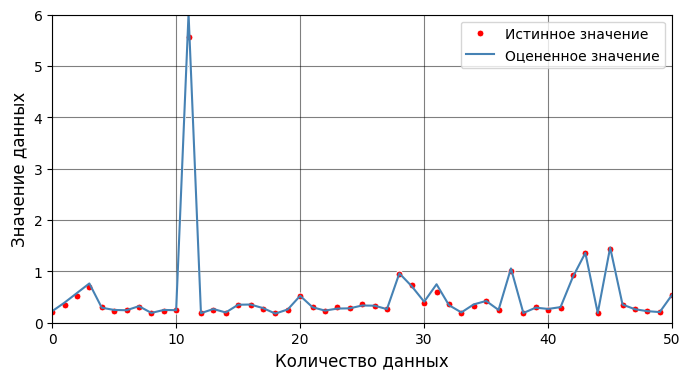

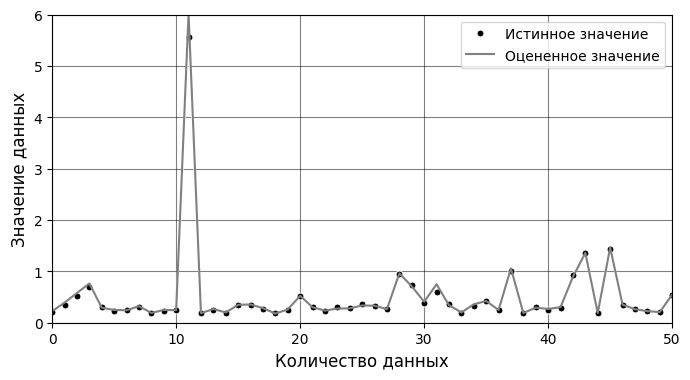

In [26]:
line_plot(test_intervals_Y[:, 0], pred[:, 0], 50, 0, "/home/jupyter/datasphere/project/uniform/Untitled Folder/val1")
line_plot(test_intervals_Y[:, 1], pred[:, 1], 50, 1, "/home/jupyter/datasphere/project/uniform/Untitled Folder/val2")
line_plot(test_intervals_Y[:, 2], pred[:, 2], 50, 2, "/home/jupyter/datasphere/project/uniform/Untitled Folder/val3")

In [27]:
learn_error_df = pd.read_csv('/home/jupyter/datasphere/project/weibull/catboost_info/learn_error.tsv', sep='\t', index_col=0)
test_error_df = pd.read_csv('/home/jupyter/datasphere/project/weibull/catboost_info/test_error.tsv', sep='\t', index_col=0)

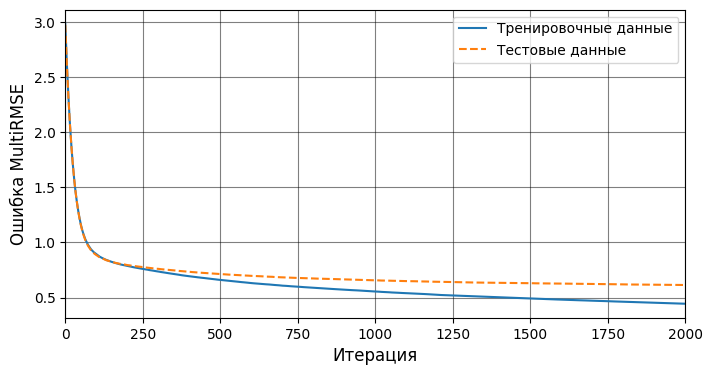

In [28]:
plt.figure(figsize=(8, 4))  # Create separate figures
sns.lineplot(np.array([list(row) for _, row in learn_error_df.iterrows()]).flatten().tolist(), label='Тренировочные данные')
sns.lineplot(np.array([list(row) for _, row in test_error_df.iterrows()]).flatten().tolist(), label='Тестовые данные', linestyle='--')  # Simplified
plt.xlim(0, 2000)
plt.xlabel('Итерация', fontsize=12)
plt.ylabel('Ошибка MultiRMSE', fontsize=12)
plt.grid(alpha=0.5, color='black')
plt.savefig('/home/jupyter/datasphere/project/uniform/catboost_train_colored_inter.pdf', bbox_inches="tight")

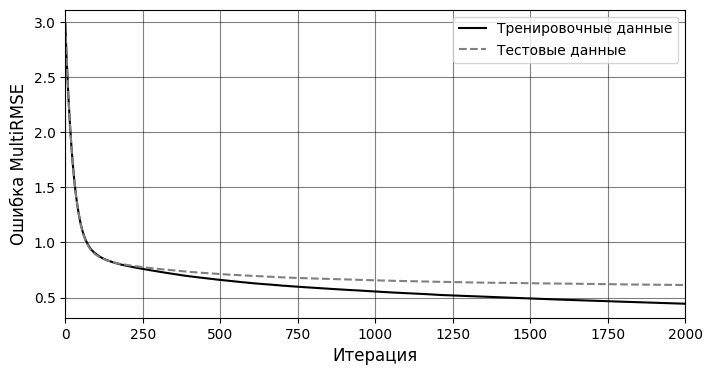

In [29]:
plt.figure(figsize=(8, 4))  # Create separate figures
sns.lineplot(np.array([list(row) for _, row in learn_error_df.iterrows()]).flatten().tolist(), label='Тренировочные данные', color='black')
sns.lineplot(np.array([list(row) for _, row in test_error_df.iterrows()]).flatten().tolist(), label='Тестовые данные', color='gray', linestyle='--')  # Simplified
plt.xlim(0, 2000)
plt.xlabel('Итерация', fontsize=12)
plt.ylabel('Ошибка MultiRMSE', fontsize=12)
plt.grid(alpha=0.5, color='black')
plt.savefig('/home/jupyter/datasphere/project/uniform/catboost_train_inter.pdf', bbox_inches="tight")

## Catboost статистика

In [30]:
train_stat_M = calculate_statistics(train_intervals_X)
test_stat_M = calculate_statistics(test_intervals_X)
val_stat_M = calculate_statistics(val_intervals_X)

In [60]:
params = {
    "loss_function": "MultiRMSE",
    "verbose": 1000,
    "random_seed": SEED,
    #"task_type": "GPU",  # Уберите, если у вас нет GPU
    "iterations": 1000,
    #"early_stopping_rounds": 1000,
    #"l2_leaf_reg": 3,
    #"depth": 8,
    #"learning_rate": 0.003
}

gamma_stat = CatBoostRegressor(**params)

# Обучение с использованием валидационной выборки
gamma_stat.fit(train_stat_M, train_intervals_Y, eval_set=(val_stat_M, val_intervals_Y), use_best_model=True)

0:	learn: 2.7552003	test: 2.6857169	best: 2.6857169 (0)	total: 7.72ms	remaining: 7.71s
999:	learn: 0.0433546	test: 0.0480911	best: 0.0480911 (999)	total: 2.49s	remaining: 0us

bestTest = 0.04809106467
bestIteration = 999



In [61]:
pred = gamma_stat.predict(test_stat_M)

In [98]:
gamma_stat.save_model("weibull")

### Метрики

In [62]:
evaluate_regression(test_intervals_Y[:, 0], pred[:, 0], "value1")
evaluate_regression(test_intervals_Y[:, 1], pred[:, 1], "value2")
evaluate_regression(test_intervals_Y[:, 2], pred[:, 2], "value3")


value1
MAE: 0.017
MSE: 0.001
RMSE: 0.023
MAPE: 7.696%
R² Score: 0.994

value2
MAE: 0.028
MSE: 0.001
RMSE: 0.036
MAPE: 0.809%
R² Score: 1.000

value3
MAE: 0.016
MSE: 0.028
RMSE: 0.168
MAPE: 0.993%
R² Score: 0.936


In [34]:
train_df, test_df = train_test_split(df, train_size=0.8, random_state=SEED, shuffle=True)
test_df, val_df = train_test_split(test_df, train_size=0.7, random_state=SEED, shuffle=True)

test_df_X = np.array(test_df)[:, :10000]
test_df_Y = np.array(test_df)[:, 10000:10002]

test_df_gen = gen_recurr(test_df_X.shape[0], test_df_X.shape[1], pred[:,0], pred[:,1])

test_interval_df_gen = get_intervals_from_df(test_df_gen.iloc[:, :10000])

In [35]:
a = test_df_X[0:test_df_X.shape[0], :test_df_X.shape[1]]
b = np.array(test_df_gen.iloc[0:test_df_X.shape[0], :test_df_X.shape[1]])

itog_itog_list = []

for i in range(test_df_X.shape[0]):
    itog_list = []
    n_cols = test_df_X.shape[1] # Store this value to avoid repeated access

    if np.max(a[i]) > np.max(b[i]): # Use NumPy's max for efficiency
        counter1 = 0
        counter2 = 0
        while counter1 < n_cols and counter2 < n_cols: #Ensure no index errors
            diff = counter1 - counter2
            if a[i][counter1] < b[i][counter2]:
                counter1 += 1
            elif a[i][counter1] > b[i][counter2]:
                counter2 += 1
            else:
                counter1 += 1
                counter2 += 1
            itog_list.append(abs(diff))
    else:
        counter1 = 0
        counter2 = 0
        while counter1 < n_cols and counter2 < n_cols: #Ensure no index errors
            diff = counter1 - counter2
            if a[i][counter1] < b[i][counter2]:
                counter1 += 1
            elif a[i][counter1] > b[i][counter2]:
                counter2 += 1
            else:
                counter1 += 1
                counter2 += 1
            itog_list.append(abs(diff))

    itog_itog_list.append(itog_list)

In [36]:
print_curve_metrics(test_intervals_df.iloc[:, :9999], test_interval_df_gen, itog_itog_list)

relative_error_mean_mean:	0.009
relative_error_mean_median:	0.006
relative_error_std_mean:	0.013
relative_error_std_median:	0.006
abs_mean:	111.393
abs_median:	85.000


### Рисунки

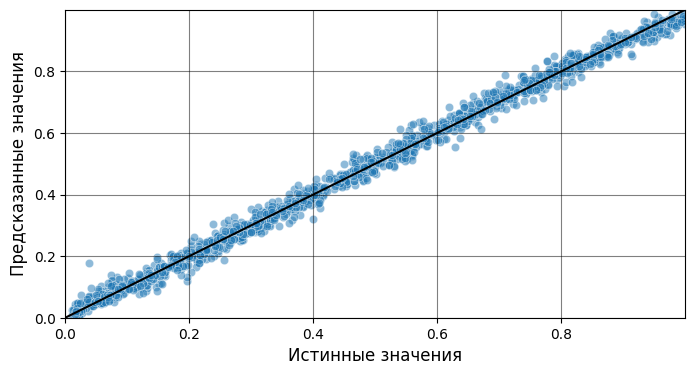

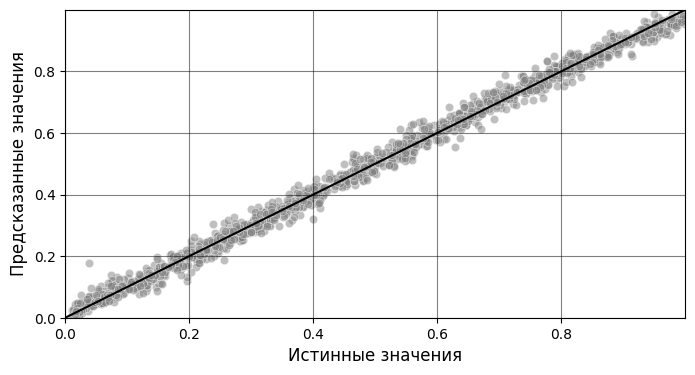

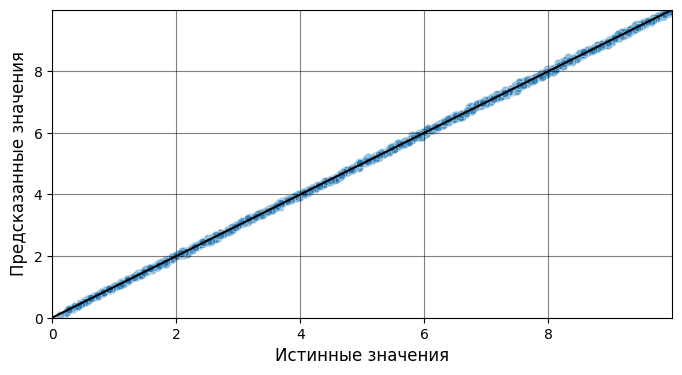

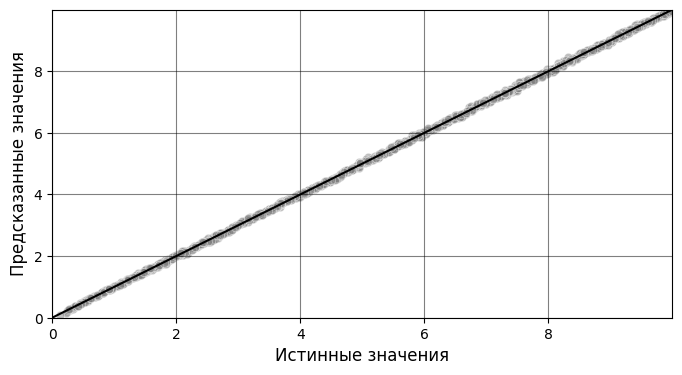

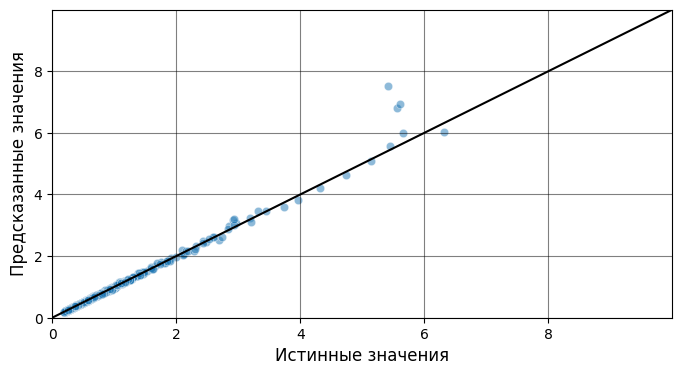

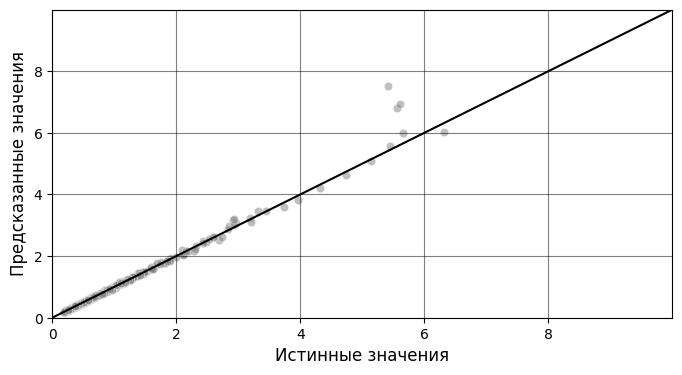

In [37]:
scatter_plot(test_intervals_Y[:,0], pred[:,0], max(test_intervals_Y[:,0]), "/home/jupyter/datasphere/project/uniform/Untitled Folder/val1_stat")

scatter_plot(test_intervals_Y[:,1], pred[:,1], max(test_intervals_Y[:,1]), "/home/jupyter/datasphere/project/uniform/Untitled Folder/val2_stat")

scatter_plot(test_intervals_Y[:,2], pred[:,2], max(test_intervals_Y[:,1]), "/home/jupyter/datasphere/project/uniform/Untitled Folder/val3_stat")

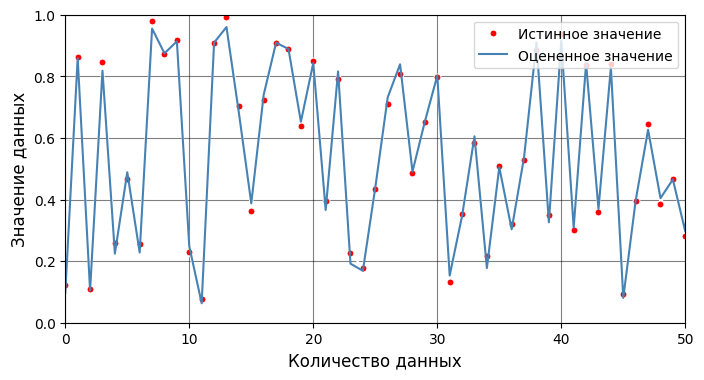

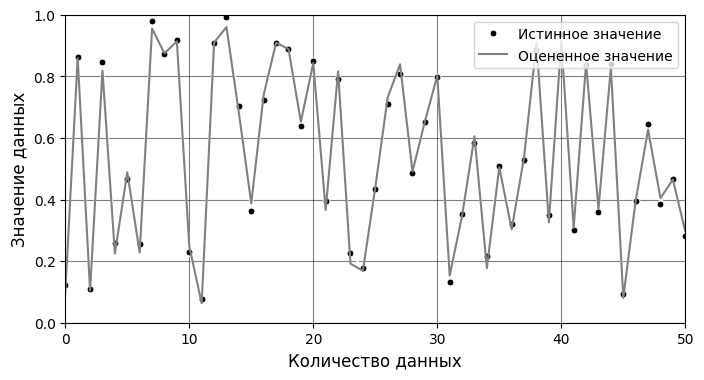

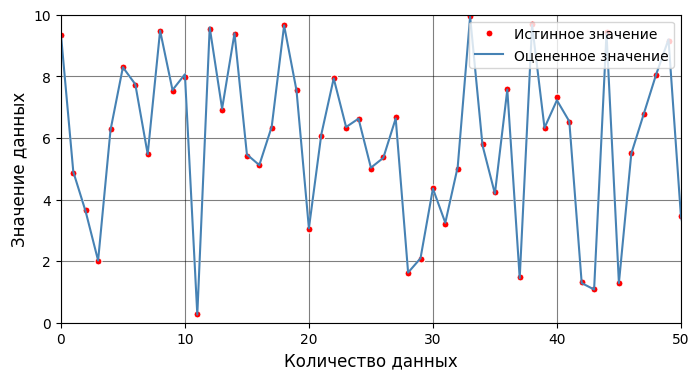

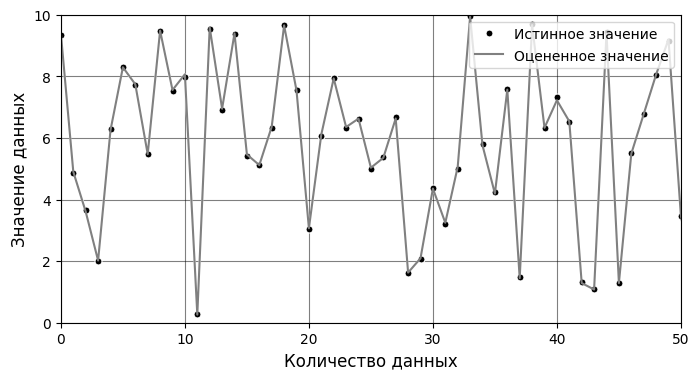

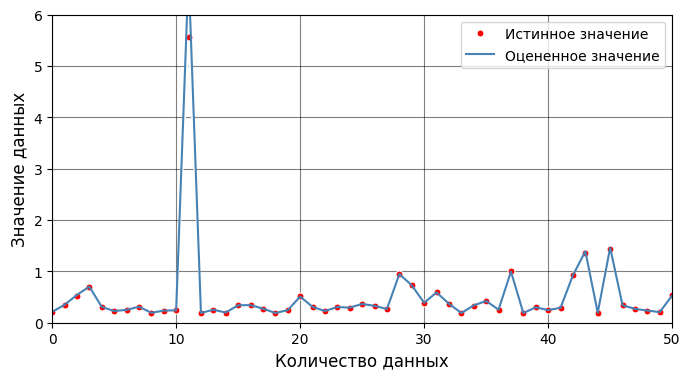

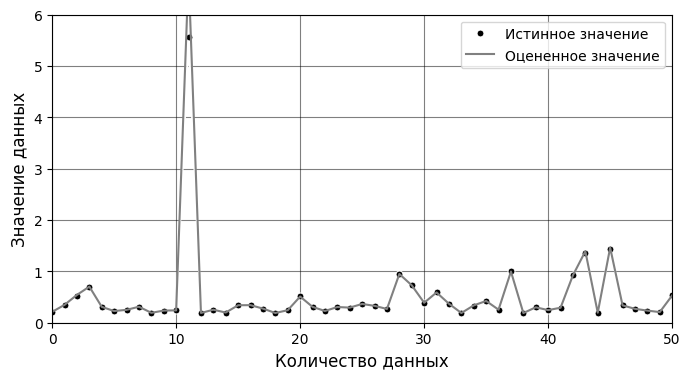

In [38]:
line_plot(test_intervals_Y[:, 0], pred[:, 0], 50, 0, "/home/jupyter/datasphere/project/uniform/Untitled Folder/val1_stat")
line_plot(test_intervals_Y[:, 1], pred[:, 1], 50, 1, "/home/jupyter/datasphere/project/uniform/Untitled Folder/val2_stat")
line_plot(test_intervals_Y[:, 2], pred[:, 2], 50, 2, "/home/jupyter/datasphere/project/uniform/Untitled Folder/val3_stat")

In [63]:
learn_error_df = pd.read_csv('/home/jupyter/datasphere/project/uniform/catboost_info/learn_error.tsv', sep='\t', index_col=0)
test_error_df = pd.read_csv('/home/jupyter/datasphere/project/uniform/catboost_info/test_error.tsv', sep='\t', index_col=0)

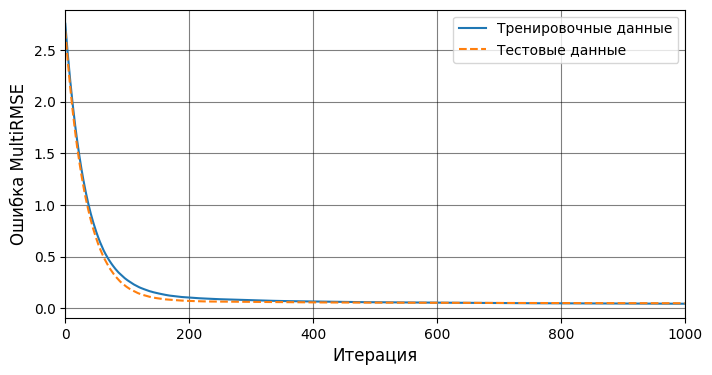

In [64]:
plt.figure(figsize=(8, 4))  # Create separate figures
sns.lineplot(np.array([list(row) for _, row in learn_error_df.iterrows()]).flatten().tolist(), label='Тренировочные данные')
sns.lineplot(np.array([list(row) for _, row in test_error_df.iterrows()]).flatten().tolist(), label='Тестовые данные', linestyle='--')  # Simplified
plt.xlim(0, 1000)
plt.xlabel('Итерация', fontsize=12)
plt.ylabel('Ошибка MultiRMSE', fontsize=12)
plt.grid(alpha=0.5, color='black')
plt.savefig('/home/jupyter/datasphere/project/uniform/catboost_train_colored__stat.pdf', bbox_inches="tight")

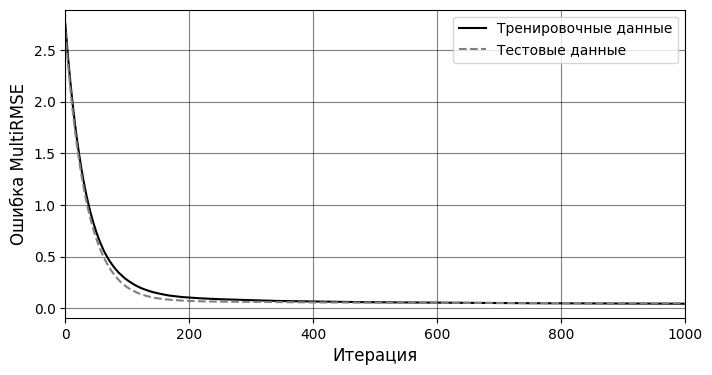

In [65]:
plt.figure(figsize=(8, 4))  # Create separate figures
sns.lineplot(np.array([list(row) for _, row in learn_error_df.iterrows()]).flatten().tolist(), label='Тренировочные данные', color='black')
sns.lineplot(np.array([list(row) for _, row in test_error_df.iterrows()]).flatten().tolist(), label='Тестовые данные', color='gray', linestyle='--')  # Simplified
plt.xlim(0, 1000)
plt.xlabel('Итерация', fontsize=12)
plt.ylabel('Ошибка MultiRMSE', fontsize=12)
plt.grid(alpha=0.5, color='black')
plt.savefig('/home/jupyter/datasphere/project/uniform/catboost_train_stat.pdf', bbox_inches="tight")

## Catboost моменты

In [42]:
train_X = np.array(train_df)[:, :10000]
train_Y = np.array(train_df)[:, 10000:]
test_X = np.array(test_df)[:, :10000]
test_Y = np.array(test_df)[:, 10000:]
val_X = np.array(val_df)[:, :10000]
val_Y = np.array(val_df)[:, 10000:]

In [44]:
params = {
    "loss_function": "MultiRMSE",
    "verbose": 100,
    "random_seed": SEED,
    #"task_type": "GPU",  # Уберите, если у вас нет GPU
    "iterations": 2000,
    "early_stopping_rounds": 200,
    #"l2_leaf_reg": 3,
    #"depth": 8,
    #"learning_rate": 0.03
}

gamma_moments = CatBoostRegressor(**params)

# Обучение с использованием валидационной выборки
gamma_moments.fit(train_X, train_Y, eval_set=(val_X, val_Y), use_best_model=True)

0:	learn: 2.7554967	test: 2.6848899	best: 2.6848899 (0)	total: 721ms	remaining: 24m 1s
100:	learn: 0.4537877	test: 0.4195814	best: 0.4195814 (100)	total: 44.2s	remaining: 13m 51s
200:	learn: 0.4014973	test: 0.4047939	best: 0.3969194 (155)	total: 1m 27s	remaining: 13m 5s
300:	learn: 0.3928473	test: 0.4096363	best: 0.3969194 (155)	total: 2m 11s	remaining: 12m 20s
Stopped by overfitting detector  (200 iterations wait)

bestTest = 0.3969194398
bestIteration = 155

Shrink model to first 156 iterations.


In [45]:
pred = gamma_moments.predict(test_X)

### Метрики

In [46]:
evaluate_regression(test_intervals_Y[:, 0], pred[:, 0], "value1")
evaluate_regression(test_intervals_Y[:, 1], pred[:, 1], "value2")
evaluate_regression(test_intervals_Y[:, 2], pred[:, 2], "value3")


value1
MAE: 0.233
MSE: 0.074
RMSE: 0.273
MAPE: 152.170%
R² Score: 0.117

value2
MAE: 0.240
MSE: 0.080
RMSE: 0.283
MAPE: 6.880%
R² Score: 0.989

value3
MAE: 0.017
MSE: 0.018
RMSE: 0.133
MAPE: 1.546%
R² Score: 0.960


In [47]:
train_df, test_df = train_test_split(df, train_size=0.8, random_state=SEED, shuffle=True)
test_df, val_df = train_test_split(test_df, train_size=0.7, random_state=SEED, shuffle=True)

test_df_X = np.array(test_df)[:, :10000]
test_df_Y = np.array(test_df)[:, 10000:10002]

test_df_gen = gen_recurr(test_df_X.shape[0], test_df_X.shape[1], pred[:,0], pred[:,1])

test_interval_df_gen = get_intervals_from_df(test_df_gen.iloc[:, :10000])

In [48]:
a = test_df_X[0:test_df_X.shape[0], :test_df_X.shape[1]]
b = np.array(test_df_gen.iloc[0:test_df_X.shape[0], :test_df_X.shape[1]])

itog_itog_list = []

for i in range(test_df_X.shape[0]):
    itog_list = []
    n_cols = test_df_X.shape[1] # Store this value to avoid repeated access

    if np.max(a[i]) > np.max(b[i]): # Use NumPy's max for efficiency
        counter1 = 0
        counter2 = 0
        while counter1 < n_cols and counter2 < n_cols: #Ensure no index errors
            diff = counter1 - counter2
            if a[i][counter1] < b[i][counter2]:
                counter1 += 1
            elif a[i][counter1] > b[i][counter2]:
                counter2 += 1
            else:
                counter1 += 1
                counter2 += 1
            itog_list.append(abs(diff))
    else:
        counter1 = 0
        counter2 = 0
        while counter1 < n_cols and counter2 < n_cols: #Ensure no index errors
            diff = counter1 - counter2
            if a[i][counter1] < b[i][counter2]:
                counter1 += 1
            elif a[i][counter1] > b[i][counter2]:
                counter2 += 1
            else:
                counter1 += 1
                counter2 += 1
            itog_list.append(abs(diff))

    itog_itog_list.append(itog_list)

In [49]:
print_curve_metrics(test_intervals_df.iloc[:, :9999], test_interval_df_gen, itog_itog_list)

relative_error_mean_mean:	0.015
relative_error_mean_median:	0.008
relative_error_std_mean:	0.268
relative_error_std_median:	0.099
abs_mean:	158.493
abs_median:	97.000


### Рисунки

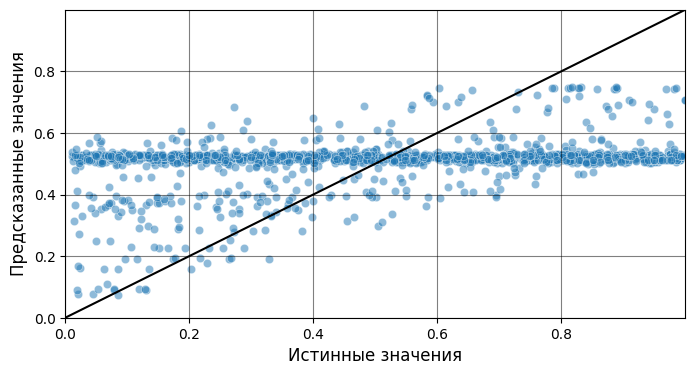

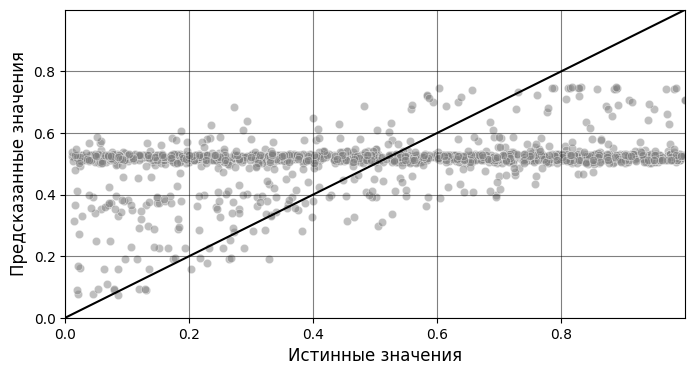

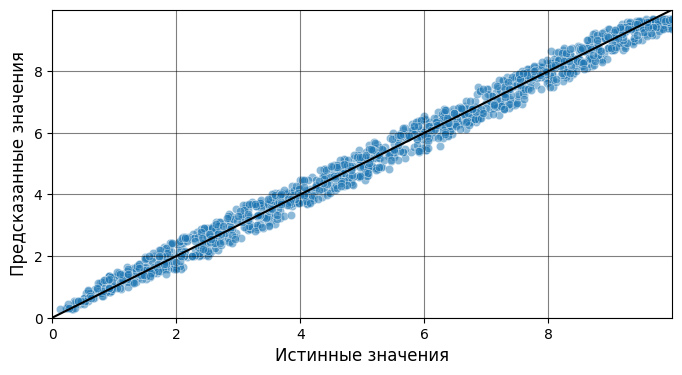

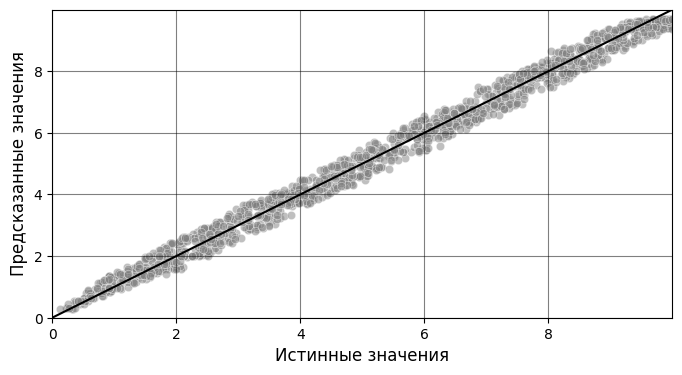

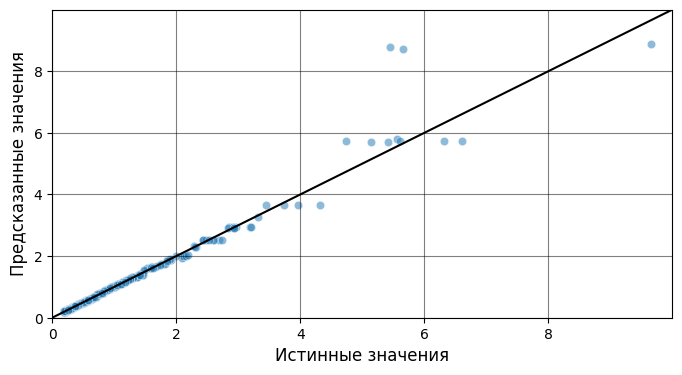

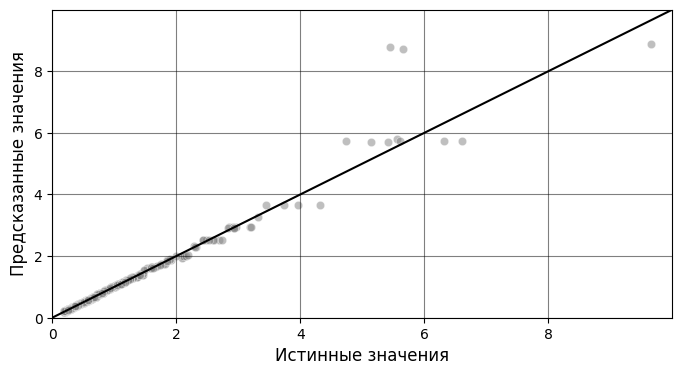

In [50]:
scatter_plot(test_intervals_Y[:,0], pred[:,0], max(test_intervals_Y[:,0]), "/home/jupyter/datasphere/project/uniform/Untitled Folder/val1_moment")

scatter_plot(test_intervals_Y[:,1], pred[:,1], max(test_intervals_Y[:,1]), "/home/jupyter/datasphere/project/uniform/Untitled Folder/val2_moment")

scatter_plot(test_intervals_Y[:,2], pred[:,2], max(test_intervals_Y[:,1]), "/home/jupyter/datasphere/project/uniform/Untitled Folder/val3_moment")

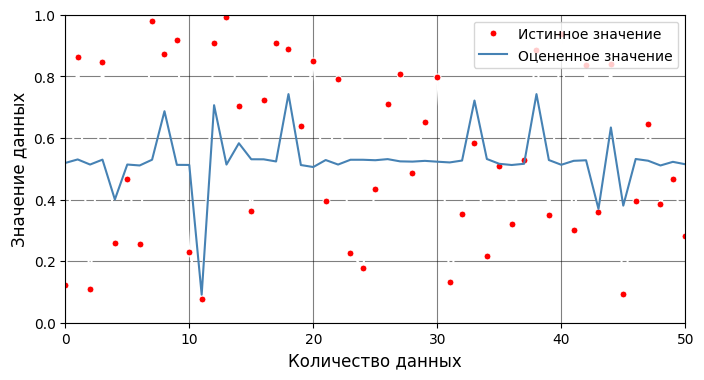

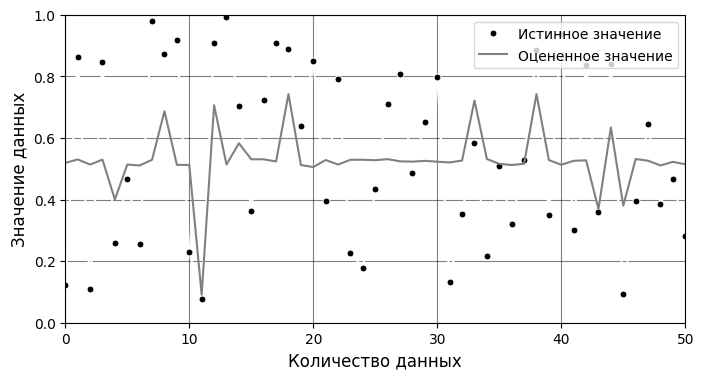

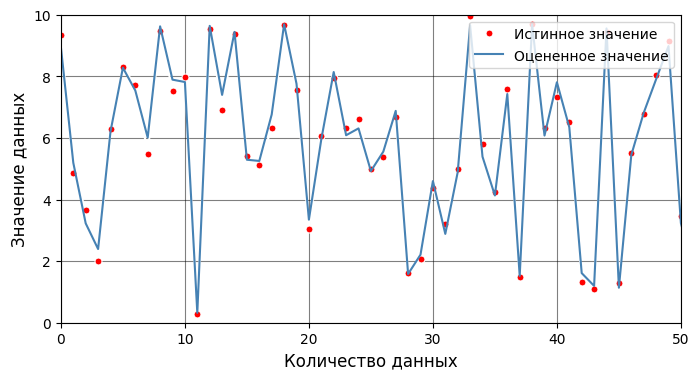

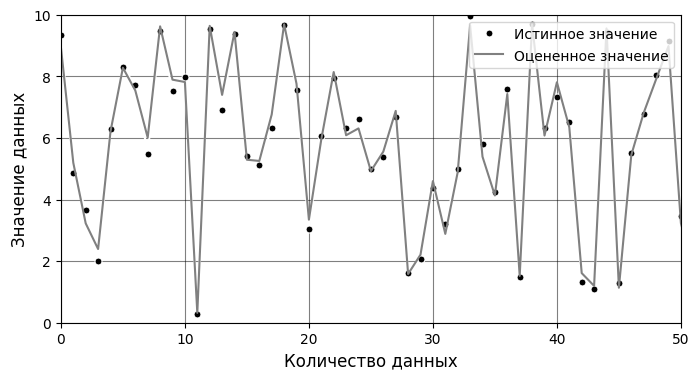

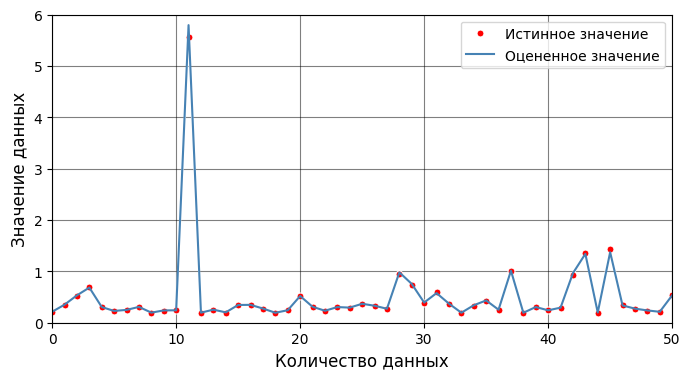

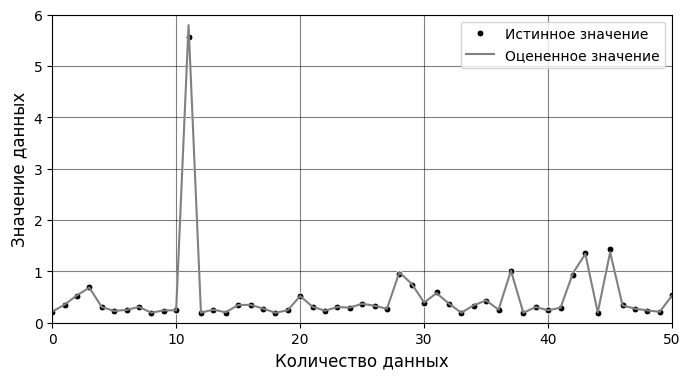

In [51]:
line_plot(test_intervals_Y[:, 0], pred[:, 0], 50, 0, "/home/jupyter/datasphere/project/uniform/Untitled Folder/val1_moment")
line_plot(test_intervals_Y[:, 1], pred[:, 1], 50, 1, "/home/jupyter/datasphere/project/uniform/Untitled Folder/val2_moment")
line_plot(test_intervals_Y[:, 2], pred[:, 2], 50, 2, "/home/jupyter/datasphere/project/uniform/Untitled Folder/val3_moment")

In [52]:
learn_error_df = pd.read_csv('/home/jupyter/datasphere/project/uniform/catboost_info/learn_error.tsv', sep='\t', index_col=0)
test_error_df = pd.read_csv('/home/jupyter/datasphere/project/uniform/catboost_info/test_error.tsv', sep='\t', index_col=0)

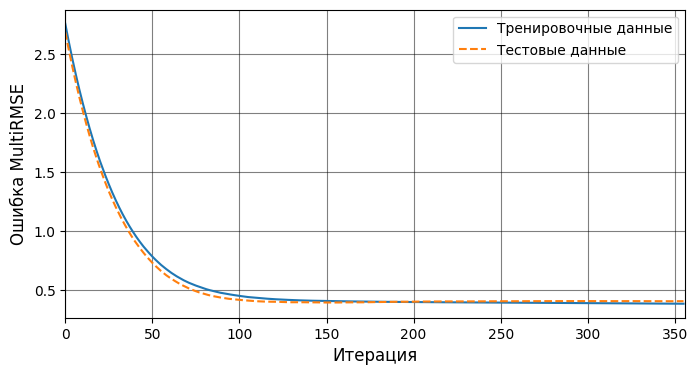

In [58]:
plt.figure(figsize=(8, 4))  # Create separate figures
sns.lineplot(np.array([list(row) for _, row in learn_error_df.iterrows()]).flatten().tolist(), label='Тренировочные данные')
sns.lineplot(np.array([list(row) for _, row in test_error_df.iterrows()]).flatten().tolist(), label='Тестовые данные', linestyle='--')  # Simplified
plt.xlim(0, len(learn_error_df))
plt.xlabel('Итерация', fontsize=12)
plt.ylabel('Ошибка MultiRMSE', fontsize=12)
plt.grid(alpha=0.5, color='black')
plt.savefig('/home/jupyter/datasphere/project/uniform/catboost_train_colored_moment.pdf', bbox_inches="tight")

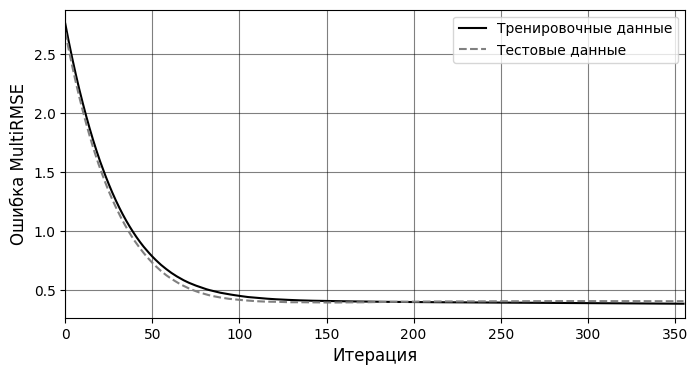

In [59]:
plt.figure(figsize=(8, 4))  # Create separate figures
sns.lineplot(np.array([list(row) for _, row in learn_error_df.iterrows()]).flatten().tolist(), label='Тренировочные данные', color='black')
sns.lineplot(np.array([list(row) for _, row in test_error_df.iterrows()]).flatten().tolist(), label='Тестовые данные', color='gray', linestyle='--')  # Simplified
plt.xlim(0, len(learn_error_df))
plt.xlabel('Итерация', fontsize=12)
plt.ylabel('Ошибка MultiRMSE', fontsize=12)
plt.grid(alpha=0.5, color='black')
plt.savefig('/home/jupyter/datasphere/project/uniform/catboost_train_moment.pdf', bbox_inches="tight")